In [1]:
import numpy as np
# import scipy as sp
# import scipy.linalg
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import torch.optim as optim

from utils import *

import matplotlib.pyplot as plt

In [2]:
def Generate_sample(nPoints):
    n = nPoints // 2
    g1 = np.random.normal(loc=-2.5, scale=1, size=n)
    g2 = np.random.normal(loc=2.5, scale=1, size=n)
    out = np.concatenate([g1, g2])
    out = out.reshape((2*n,1))
    return out 

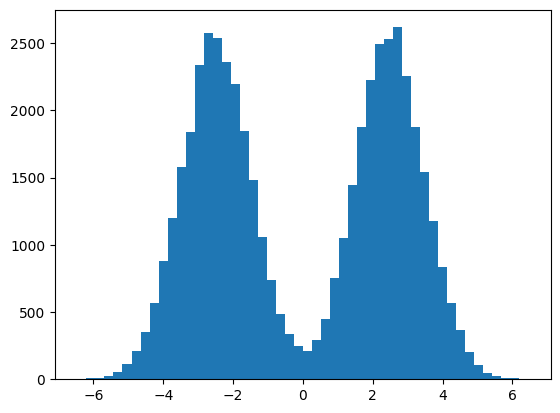

In [3]:
sample = Generate_sample(50000)


fig, ax = plt.subplots()
ax.hist(sample, bins=50)
plt.show()

In [4]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, dim, flows):
        super().__init__()
        self.prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        bsz, _ = x.shape
        log_det = torch.zeros(bsz)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        bsz, _ = z.shape
        log_det = torch.zeros(bsz)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

In [5]:
class FCNN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim+128),
            nn.Tanh(),
            nn.Linear(hidden_dim+128, hidden_dim+64),
            nn.Tanh(),
            nn.Linear(hidden_dim+64, hidden_dim+16),
            nn.Tanh(),
            nn.Linear(hidden_dim+16, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),         
        )

    def forward(self, x):
        return self.network(x)

In [6]:
class NSF_AR(nn.Module):
    def __init__(self, dim, K = 10, B = 6, hidden_dim = 8, base_network = FCNN):
        super().__init__()
        self.dim = dim
        self.K = K
        self.B = B
        self.layers = nn.ModuleList()
        self.init_param = nn.Parameter(torch.Tensor(3 * K - 1))
        for i in range(1, dim):
            self.layers += [base_network(i, 3 * K - 1, hidden_dim)]
 

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0])
        for i in range(self.dim):
            if i == 0:
                init_param = self.init_param.expand(x.shape[0], 3 * self.K - 1)
                W, H, D = torch.split(init_param, self.K, dim = 1)
            else:
                out = self.layers[i - 1](x[:, :i])
                W, H, D = torch.split(out, self.K, dim = 1)
            W, H = torch.softmax(W, dim = 1), torch.softmax(H, dim = 1)
            W, H = 2 * self.B * W, 2 * self.B * H
            D = F.softplus(D)
            z[:, i], ld = unconstrained_RQS(
                x[:, i], W, H, D, inverse=False, tail_bound=self.B)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(x.shape[0])
        for i in range(self.dim):
            if i == 0:
                init_param = self.init_param.expand(x.shape[0], 3 * self.K - 1)
                W, H, D = torch.split(init_param, self.K, dim = 1)
            else:
                out = self.layers[i - 1](x[:, :i])
                W, H, D = torch.split(out, self.K, dim = 1)
            W, H = torch.softmax(W, dim = 1), torch.softmax(H, dim = 1)
            W, H = 2 * self.B * W, 2 * self.B * H
            D = F.softplus(D)
            x[:, i], ld = unconstrained_RQS(
                z[:, i], W, H, D, inverse = True, tail_bound = self.B)
            log_det += ld
        return x, log_det

In [7]:
n_samples = 10000
epochs = 1501

flow = NSF_AR
flows = [flow(dim=1) for _ in range(2)]
model = NormalizingFlowModel(dim=1, flows=flows)

optimizer = optim.Adam(model.parameters(), lr=0.005)
x = torch.Tensor(Generate_sample(n_samples))
print(x.shape)

# for i in range(x.shape[1]):
#     x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])

for i in range(epochs):
    optimizer.zero_grad()
    z, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(prior_logprob + log_det)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print("Iter: ", i, "    Loss: ", loss)
        print("Logprob: ", logprob.mean().data)
        print("Prior: ", prior_logprob.mean().data)
        print("LogDet: ", log_det.mean().data)

torch.Size([10000, 1])
Iter:  0     Loss:  tensor(4.5561, grad_fn=<NegBackward0>)
Logprob:  tensor(-4.5561)
Prior:  tensor(-4.5521)
LogDet:  tensor(-0.0040)
Iter:  100     Loss:  tensor(2.2359, grad_fn=<NegBackward0>)
Logprob:  tensor(-2.2359)
Prior:  tensor(-1.5610)
LogDet:  tensor(-0.6749)
Iter:  200     Loss:  tensor(2.1160, grad_fn=<NegBackward0>)
Logprob:  tensor(-2.1160)
Prior:  tensor(-1.4700)
LogDet:  tensor(-0.6459)
Iter:  300     Loss:  tensor(2.0969, grad_fn=<NegBackward0>)
Logprob:  tensor(-2.0969)
Prior:  tensor(-1.4451)
LogDet:  tensor(-0.6518)
Iter:  400     Loss:  tensor(2.0940, grad_fn=<NegBackward0>)
Logprob:  tensor(-2.0940)
Prior:  tensor(-1.4406)
LogDet:  tensor(-0.6534)
Iter:  500     Loss:  tensor(2.0928, grad_fn=<NegBackward0>)
Logprob:  tensor(-2.0928)
Prior:  tensor(-1.4376)
LogDet:  tensor(-0.6553)
Iter:  600     Loss:  tensor(2.0921, grad_fn=<NegBackward0>)
Logprob:  tensor(-2.0921)
Prior:  tensor(-1.4349)
LogDet:  tensor(-0.6572)
Iter:  700     Loss:  tenso

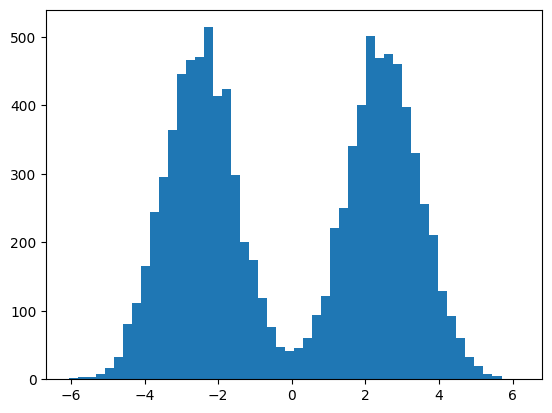

In [8]:
fig, ax = plt.subplots()
ax.hist(x.numpy(), bins=50)
plt.show()

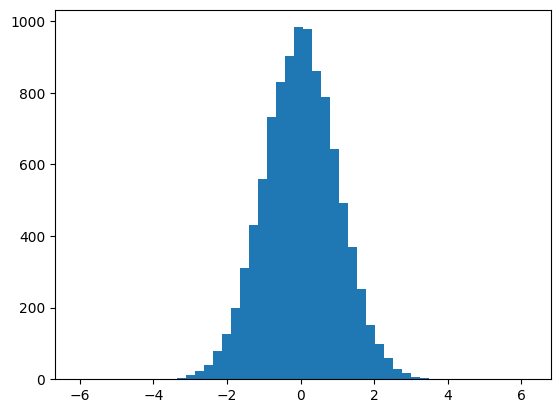

In [9]:
fig, ax = plt.subplots()
ax.hist(z.data.numpy(), bins=50)
plt.show()

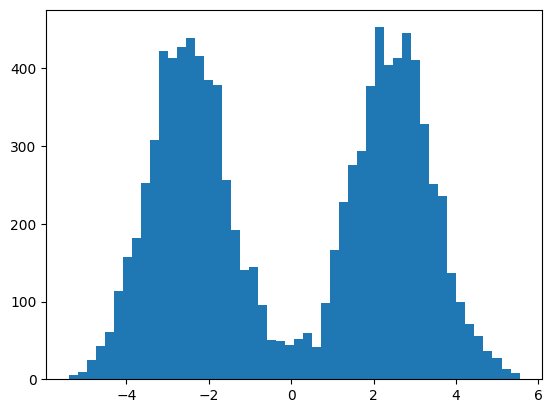

In [10]:
samples = model.sample(10000).data
fig, ax = plt.subplots()
#ax.set_xlim((-3,3))
ax.hist(samples.numpy(), bins=50)
plt.show()